Shell for the functions needed for the gpt model

In [14]:
import jax
import jax.numpy as jnp
from flax import linen as nn
from flax.training import train_state
import optax
import math
import os
from tqdm.auto import tqdm
import tiktoken
import matplotlib.pyplot as plt
import orbax.checkpoint as ocp
from flax.training import orbax_utils
from functools import partial
import numpy as np


key = jax.random.PRNGKey(42)

In [15]:
# Hyperparameters
batch_size = 8
context_length = 512
train_test_split_size = 0.9
embed_dim = 264
n_heads = 12
mlp_dim_mul = 4  # between 2 and 8 according to UvA
n_blocks = 12
max_iters = 3000
learning_rate = 3e-4

# Scheduler
use_scheduler = False
scheduler_warmup_steps = 200  # typically 5-10% of the total training steps
scheduler_decay_steps = max_iters  #  Positive integer, the total length of the schedule
init_value = 3e-4
peak_value = 0.05

# Generation
temperature = 1

# Checkpoints
delete_checkpoints = True
CHECKPOINT_PATH = "/Users/akseljoonas/Documents/Kool/NN/Final Project/checkpoints"

# Parallelising
devices = jax.local_devices()
print(devices)

# Check if hyperparams make sense
assert embed_dim % n_heads == 0
assert scheduler_decay_steps <= max_iters
assert scheduler_warmup_steps <= scheduler_decay_steps

[CpuDevice(id=0)]


In [16]:
def open_data(folder_path="./dataset"):
    def remove_char(pre_nietzsche_data):
        n_nietzsche_data = pre_nietzsche_data.replace("_", "")
        nietzsche_data = n_nietzsche_data.replace("$", "")
        return nietzsche_data

    full_txt = ""
    for path in os.listdir(folder_path):
        if ".txt" in path and 'niet' in path:
            txt = open(os.path.join(folder_path, path), "r", encoding="utf-8").read()
            txt = remove_char(txt)
            full_txt += txt
    return full_txt


text = open_data()
len(text)

3396780

In [27]:
class Tokenizer:
    """
    Class that takes care of encoding and decoding the text
    """

    def __init__(self, text: str, tokenizer_type: str = "base") -> None:
        self.tokenizer_type = tokenizer_type

        if self.tokenizer_type == "base":
            self.vocab_size, self.all_characters = self.sort_characters(text)
        elif self.tokenizer_type == "gpt-2":
            self.enc = tiktoken.encoding_for_model("gpt-2")
            self.vocab_size = self.enc.n_vocab

    def get_vocab_size(self):
        return int(jnp.copy(self.vocab_size))

    def sort_characters(self, data):
        all_characters = sorted(list(set(data)))
        vocab_size = len(all_characters)

        return vocab_size, all_characters

    def encode(self, text):
        encoded_text = []
        if self.tokenizer_type == "base":
            for c in text:
                num = self.all_characters.index(c)
                encoded_text.append(num)
        elif self.tokenizer_type == "gpt-2":
            encoded_text = self.enc.encode(text)
        return jnp.array(encoded_text)

    def decode(self, encoded_text):
        text = []
        if self.tokenizer_type == "base":
            for n in encoded_text:
                char = self.all_characters[n]
                text.append(char)
            text = "".join([str(item) for item in text])

        elif self.tokenizer_type == "gpt-2":
            text = self.enc.decode(encoded_text)

        return text

In [28]:
tokenizer = Tokenizer(text=text, tokenizer_type="gpt-2") 
all_data = tokenizer.encode(text)
tokenizer.get_vocab_size()

50257

In [29]:
# test tokenizer
print(tokenizer.decode(all_data[:100]))

What I am now going to relate is the history of the next two centuries.
I shall describe what will happen, what must necessarily happen:
the triumph of Nihilism. This history can be written already; for
necessity itself is at work in bringing it about. This future is
already proclaimed by a hundred different omens; as a destiny it
announces its advent everywhere, for this music of to-morrow all ears
are already pricked.


In [7]:
class BatchLoader:
    def __init__(self, data, train_test_split_size, key) -> None:
        self.training_data, self.validation_data = self.splitting_data(
            data, train_test_split_size
        )
        self.key = key

    def splitting_data(self, data, split_size):
        n = int(split_size * len(data))
        training_data = data[:n]
        validation_data = data[n:]
        return training_data, validation_data

    def get_batch(self, batch_size, context_length, training: bool = True):
        train_batches = []
        target_batches = []

        if training:
            b_data = self.training_data
        else:
            b_data = self.validation_data

        for _ in range(batch_size):
            self.key, subkey = jax.random.split(self.key)
            pos = jax.random.randint(
                key=subkey, shape=(), minval=0, maxval=(len(b_data) - context_length)
            )
            batch_data = b_data[pos : pos + context_length]
            train_batches.append(batch_data)
            batch_data = b_data[pos + 1 : pos + context_length + 1]
            target_batches.append(batch_data)

        train_batches = jnp.stack(train_batches)
        target_batches = jnp.stack(target_batches)

        return train_batches, target_batches

In [8]:
batch_loader = BatchLoader(data=all_data, train_test_split_size=train_test_split_size, key=key)
train, targets = batch_loader.get_batch(batch_size, context_length, training=True)
print(train.shape)
print(targets.shape)

(8, 512)
(8, 512)


In [9]:
class SingleAttentionHead(nn.Module):
    embed_dim: int
    head_size: int

    def setup(self):
        self.key = nn.Dense(self.head_size, use_bias=False) 
        self.query = nn.Dense(self.head_size, use_bias=False)
        self.value = nn.Dense(self.head_size, use_bias=False)
        self.dropout = nn.Dropout(rate=0.2)

    def __call__(self, data, training):
        
        k = self.key(data)  # from embed_dim to head_size (B,T,C)
        q = self.query(data) # from embed_size to head_size (B,T,C)
        v = self.value(data) # from embed_size to head_size (B,T,C)

        weights = jnp.matmul(q,jnp.swapaxes(k, -2,-1)) / math.sqrt(self.head_size) # (B,T,T)
        
        #Lower triangular mask matrix of the size B, T, C (same btw as attention)
        mask = jnp.tril(weights)
        
        # for every zero, make it to -inf 
        weights = nn.softmax(jnp.where(mask == 0, -9e16, weights), axis=-1) # axis=-1 since we only want to softmax for each row of T not for the whole data as a whole
        
        weights = self.dropout(weights, deterministic = not training)

        attention = jnp.matmul(weights, v) # (B,T,C)

        return attention

In [10]:
class MultiHeadAttention(nn.Module):
    """
    Multiple attention heads combined together
    """

    head_num: int
    embed_dim: int

    def setup(self):
        self.heads = [
            SingleAttentionHead(
                embed_dim=self.embed_dim, head_size=self.embed_dim // self.head_num
            )
            for _ in range(self.head_num)
        ]
        self.think = nn.Dense(self.embed_dim, use_bias=False)
        self.dropout = nn.Dropout(rate=0.2)

    def __call__(self, data, training):
        multiple_attentions = jnp.concatenate(
            [head(data, training) for head in self.heads], axis=-1
        )
        thoughts = self.think(multiple_attentions)
        out = self.dropout(thoughts, deterministic = not training)
        return out

In [11]:
class FeedForward(nn.Module):
    '''Simple Feed Forward NN that goes from embed_dim to a higher dimension and then back to embed_dim'''
    
    embed_dim: int
    dim_mul: int

    def setup(self):
        #this is the heavy thinking part of the model, where it tries to make sense of what was learned
        # in the attention cycle lol
        self.layer1 = nn.Dense(features=(self.dim_mul*self.embed_dim), use_bias=False)
        self.layer2 = nn.Dense(features=self.embed_dim, use_bias=False)
        self.dropout = nn.Dropout(rate=0.2)

    def __call__(self, data, training: bool):
        x = data
        x = self.layer1(x)
        x = nn.relu(x)
        x = self.layer2(x)
        x = self.dropout(x, deterministic = not training)
        return x

In [12]:
class Block(nn.Module):
    '''One run through a block, which consists of MultiheadAttention + Feedforward + Layer Normalisation'''
    dim_mul: int
    embed_dim: int
    head_num: int
    
    def setup(self):
        self.norm1 = nn.LayerNorm()
        self.norm2 = nn.LayerNorm()
        self.multihead = MultiHeadAttention(head_num = self.head_num, embed_dim=self.embed_dim)
        self.feedforward = FeedForward(embed_dim=self.embed_dim, dim_mul=self.dim_mul)
    
    def __call__(self, data, training: bool):
        x = data
        x = x + self.multihead(self.norm1(x), training)
        x = x + self.feedforward(self.norm2(x), training)

        return x

In [13]:
class CustomSequential(nn.Module):
    layers: list

    @nn.compact
    def __call__(self, x, *args, **kwargs):
        for layer in self.layers:
            x = layer(x, *args, **kwargs)
        return x

In [14]:
class TransformerModel(nn.Module):
    vocab_size: int
    context_length: int
    embed_dim: int
    head_num: int
    dim_mul: int
    n_blocks: int

    def setup(self):
        self.token_embedding_table = nn.Embed(self.vocab_size, self.embed_dim)
        self.position_embedding_table = nn.Embed(self.context_length, self.embed_dim)
        #########################
        self.blocks = CustomSequential(
            [
                Block(
                    head_num=self.head_num,
                    embed_dim=self.embed_dim,
                    dim_mul=self.dim_mul,
                )
                for _ in range(self.n_blocks)
            ]
        )

        #########################
        self.norm = nn.LayerNorm()
        self.linear = nn.Dense(self.vocab_size, use_bias=False)

    def __call__(self, data, training: bool = True):
        _, context_length = data.shape

        token = self.token_embedding_table(data)
        position = self.position_embedding_table(jnp.arange(context_length))

        embedded_data = token + position

        iteration_data = self.blocks(
            embedded_data, training
        )  # data after one iteration MH,FF (4,8,32)
        data_normalized = self.norm(iteration_data)
        final_data = self.linear(data_normalized)

        return final_data

In [15]:
# Optimizer
scheduler = optax.warmup_cosine_decay_schedule(
    init_value=init_value,
    peak_value=peak_value,
    warmup_steps=scheduler_warmup_steps,
    decay_steps=scheduler_decay_steps,
)
if use_scheduler:
    optimizer = optax.adamw(scheduler) # scheduler
else:
    optimizer = optax.adamw(learning_rate) # scheduler

In [16]:
# Model init
data = jnp.ones(
    (batch_size, context_length), dtype=jnp.int32
)


model = TransformerModel(
    vocab_size=tokenizer.get_vocab_size(),
    context_length=context_length,
    embed_dim=embed_dim,
    head_num=n_heads,
    dim_mul=mlp_dim_mul,
    n_blocks=n_blocks,
)

# specify what the key is used
key, param_key, dropout_key = jax.random.split(key, num=3)
variables = model.init(param_key, data=data, training=False)

In [17]:
# Training State
params = variables["params"]

orbax_checkpointer = ocp.PyTreeCheckpointer()

dir_path = CHECKPOINT_PATH


class TrainState(train_state.TrainState):
    key: jax.Array


if not os.path.exists(dir_path):
    os.mkdir(dir_path)


if delete_checkpoints:
    path = ocp.test_utils.erase_and_create_empty(dir_path)


if len(os.listdir(dir_path)) > 0:  # If we have saved checkpoints
    subdirs = sorted((int(d) for d in os.listdir(dir_path)), reverse=True)
    best_model_dir = os.path.join(dir_path, str(subdirs[0]) + "/default/")
    print(f"Loaded state {best_model_dir}")
    empty_state = TrainState.create(
        apply_fn=model.apply,
        params=jax.tree_util.tree_map(np.zeros_like, params),
        key=dropout_key,
        tx=optimizer,
    )
    target = {"model": empty_state}
    state = orbax_checkpointer.restore(best_model_dir, item=target)["model"]
    path = dir_path
else:
    state = TrainState.create(
        apply_fn=model.apply, params=params, key=dropout_key, tx=optimizer
    )

In [18]:
# Checkpoints
options = ocp.CheckpointManagerOptions(max_to_keep=3)
checkpoint_manager = ocp.CheckpointManager(path, orbax_checkpointer, options)

In [19]:
@partial(jax.pmap, axis_name="batch")
@jax.jit  # Jit the function for efficiency
def _train_step(state, batch, dropout_key):
    dropout_key, dropout_train_key = jax.random.split(dropout_key)

    def loss_fn(params):
        data, labels = batch

        # Same as model.apply
        logits = state.apply_fn(
            {"params": params}, data, training=True, rngs={"dropout": dropout_train_key}
        )

        loss = optax.softmax_cross_entropy_with_integer_labels(logits, labels)
        mean_loss = jnp.mean(loss)

        return mean_loss, logits

    # Gradient function
    grad_fn = jax.value_and_grad(
        loss_fn,  # Function to calculate the loss
        has_aux=True,  # Function has additional outputs, here accuracy
    )
    # Determine gradients for current model, parameters and batch
    (loss, logits), grads = grad_fn(state.params)

    # Perform parameter update with gradients and optimizer
    state = state.apply_gradients(grads=grads)
    # Return state and any other value we might want
    return state, loss


@partial(jax.pmap, axis_name="batch")
@jax.jit  # Jit the function for efficiency
def _eval_step(state, batch):
    data, labels = batch
    logits = state.apply_fn({"params": state.params}, data, training=False)

    loss = optax.softmax_cross_entropy_with_integer_labels(logits, labels)
    mean_loss = jnp.mean(loss)

    return mean_loss


In [20]:
def train(state, num_epochs, dropout_key):
    replicated_state = jax.device_put_replicated(state, jax.local_devices())
    train_losses = []
    eval_losses = []
    best_eval_loss = float("inf")

    for epoch in tqdm(range(num_epochs + 1)):
        # Get data
        train, train_labels = batch_loader.get_batch(
            batch_size, context_length, training=True
        )

        # Reshaping to be compatiple with pmap
        dropout_keys = jax.random.split(dropout_key, jax.local_device_count())
        train = train.reshape((jax.local_device_count(), -1, *train.shape[1:]))
        train_labels = train_labels.reshape(
            (jax.local_device_count(), -1, *train_labels.shape[1:])
        )

        # Train step
        train_batch = (train, train_labels)
        replicated_state, gpu_train_losses = _train_step(
            replicated_state, train_batch, dropout_keys
        )

        # Get mean loss across gpus
        train_loss = jnp.mean(gpu_train_losses)

        if epoch % 100 == 0:
            # Get data
            eval, eval_labels = batch_loader.get_batch(
                batch_size, context_length, training=False
            )

            # Reshaping to be compatiple with pmap
            eval = eval.reshape((jax.local_device_count(), -1, *eval.shape[1:]))
            eval_labels = eval_labels.reshape(
                (jax.local_device_count(), -1, *eval_labels.shape[1:])
            )

            # Eval step
            eval_batch = (eval, eval_labels)
            gpu_eval_losses = _eval_step(replicated_state, eval_batch)

            # Get mean loss across gpus
            eval_loss = jnp.mean(gpu_eval_losses)

            # Saving best model according to loss
            if eval_loss < best_eval_loss:
                print(f"Saved model with loss {eval_loss}")
                ckpt = {"model": jax.device_get(replicated_state)}
                save_args = orbax_utils.save_args_from_target(ckpt)     
                
                checkpoint_manager.save(
                    epoch,
                    ckpt,
                    save_kwargs={"save_args": save_args},
                )
                checkpoint_manager.wait_until_finished()
                best_eval_loss = eval_loss

            # Appending losses
            train_losses.append(train_loss)
            eval_losses.append(eval_loss)

            print(f"Epoch {epoch}: Train loss {train_loss}, Eval loss {eval_loss}")

    return jax.device_get(replicated_state), train_losses, eval_losses


def plot_loss_curves(train_losses, eval_losses, eval_interval=100):
    epochs = range(len(train_losses))

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, label="Training Loss")
    plt.plot(epochs, eval_losses, label="Evaluation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Evaluation Loss Curves")
    plt.legend()
    plt.show()

  0%|          | 0/3001 [00:00<?, ?it/s]

Saved model with loss 11.555063247680664
Epoch 0: Train loss 12.669288635253906, Eval loss 11.555063247680664
Saved model with loss 6.75614070892334
Epoch 100: Train loss 6.998126029968262, Eval loss 6.75614070892334
Saved model with loss 6.603386402130127
Epoch 200: Train loss 6.622734069824219, Eval loss 6.603386402130127
Epoch 300: Train loss 6.722262382507324, Eval loss 6.843350410461426
Epoch 400: Train loss 6.788339614868164, Eval loss 6.973452568054199
Epoch 500: Train loss 6.61543083190918, Eval loss 6.866742134094238
Epoch 600: Train loss 6.717040061950684, Eval loss 6.717058181762695
Epoch 700: Train loss 6.778999328613281, Eval loss 6.706072807312012
Epoch 800: Train loss 6.5868096351623535, Eval loss 6.836806774139404
Epoch 900: Train loss 6.965482711791992, Eval loss 6.759293079376221
Epoch 1000: Train loss 6.77341365814209, Eval loss 6.616564750671387
Epoch 1100: Train loss 6.882269859313965, Eval loss 6.604053497314453
Epoch 1200: Train loss 6.80185604095459, Eval loss 6

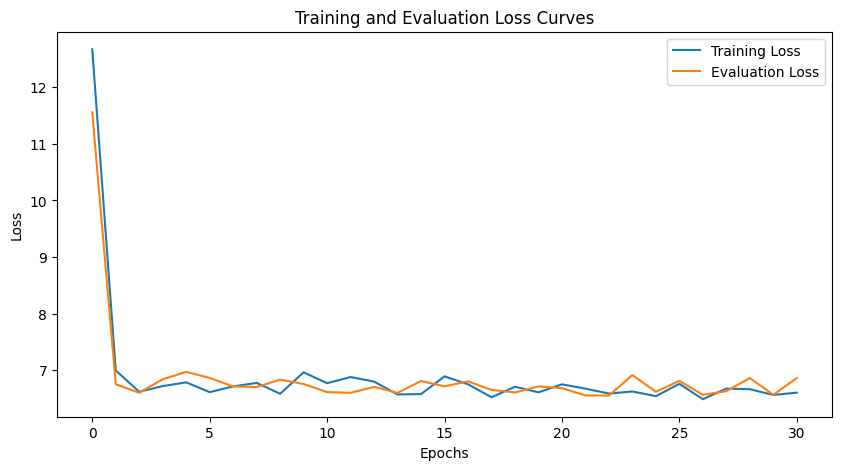

In [21]:
# Training

trained_model_state, train_losses, eval_losses = train(
    state=state, num_epochs=max_iters, dropout_key=dropout_key
)
plot_loss_curves(train_losses, eval_losses)

In [22]:
@partial(jax.pmap, axis_name="batch", static_broadcasted_argnums=(4))
@jax.jit
def generate_step(state, key, data, params, temperature):
    data_to_use = data[:, -context_length:]

    logits = state.apply_fn({"params": params}, data_to_use, training=False)
    logits = logits[:, -1, :]

    next_token = jax.random.categorical(key, logits / temperature, shape=(1, 1))

    data = jnp.concatenate((data, next_token), axis=1)
    return data


def generate(state, data, length, temperature):
    params = state.params
    key = jax.random.PRNGKey(42)
    for _ in tqdm(range(length)):
        key, subkey = jax.random.split(key)
        generate_keys = jax.random.split(subkey, jax.local_device_count())
        data = generate_step(state, generate_keys, data, params, temperature)

    return jax.device_get(data[0])

In [24]:
# Generation

PROMPT = jnp.ones(
    (jax.device_count(), 1, 1), dtype=jax.numpy.int32
)  # (device_count, 1, 1)

generated_seq = generate(
    trained_model_state,
    PROMPT,
    500,
    temperature,
)

print(generated_seq)
decoded_text = tokenizer.decode(generated_seq[0])

print(decoded_text)

  0%|          | 0/500 [00:00<?, ?it/s]

[[     1    385     11    306    316    364    326    412    326    326
      11    484  10591   5124    198   8431 171666   6062    306   2325
      11    540    364    326   1577   2447 191963  25920     13   1062
   13350   1101    328  31994    316    503   2086 133882  16010    316
    1938    268    316   5025  16623  10175  50474    316   7330    483
     307  77020   7027  13531     11    936   1511  10740   1879   5073
   92061    198    316    976   7845   1043     11   5073    581    328
   76168   9948    198     76    198  28449    562 197859    945   1039
   51041    328    275    364   1606   1206    412   1938     26  15458
    1504 167223    326  15801   1775   1236    321    326    621    198
  186441    364   1328    198  96488    316    679    290    357     26
   66005    290  65432    326    963   2226   5733  23062    261  57404
     306 187582  83839   8115    501     11    673    336    328     11
    1001   9623    198  61745   1118   1841    540    198    779